## Movie Recommendation using Collaborative Filtering

Also known as User-User Filtering. 

It uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the Pearson Correlation Function.




In [ ]:
# Improt statements

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline


Reading the datasets that we have. We will need movies and the ratings files. 

In [ ]:
movie = pd.read_csv('movies.csv')
rating= pd.read_csv('ratings.csv')

Quick view of the two dataframes, the rows and the columns

In [ ]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
rating.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


## Preprocessing the dataset

We remove the year from the title in the movie dataframe and add a separate year column using pandas' replace function.
Regular expressions are used to do this. Between the parenthesis, look for a year. We use parantheses to avoid clashing with films that include years in their names.

First we create the new Year column in the movie dataframe.

In [ ]:
movie['year'] = movie.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movie['year'] = movie.year.str.extract('(\d\d\d\d)',expand=False)

Now removing the year from the title in the Title column. 

In [ ]:
#Removing the years from the 'title' column
movie['title'] = movie.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movie['title'] = movie['title'].apply(lambda x: x.strip())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# Get genre info
genres = movie
genres['genres'] = genres['genres'].str.split('|')
genres = genres.explode('genres')

In [ ]:
movie.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [ ]:
genres.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure,1995
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children,1995
0,1,Toy Story,Comedy,1995
0,1,Toy Story,Fantasy,1995


Collaborative filtering does not make recommendations based on the movie's features. The recommendation is based on the likes and dislikes of the neighbors or other users, as well as their ratings.
As a result, the genre column will be removed because it is no longer useful.

In [ ]:
movie.drop(columns=['genres'], inplace=True)

In [ ]:
movie.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


When it comes to the ratings dataframe, the movieId field is the same as it is in the movie dataframe. Each user has assigned several ratings to various films. The recommendation algorithm does not require the column Timestamp. As a result, we can let it go.

In [ ]:
rating.drop(columns=['timestamp'],inplace=True)

In [ ]:
rating.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


## Some stats about the data

In [ ]:
rating_info = rating.nunique()
print("Number of users: ", rating_info['userId'])
print("Number of movies: ", rating_info['movieId'])
print("Number of ratings: ", rating.count()['rating'])
print("Minimum rating: ", rating.min())
print("Maximum rating: ", rating.max())

movie_info = movie.nunique()
print("Number of movie-titles: ", movie_info['title'])

Number of users:  283228
Number of movies:  53889
Number of ratings:  27753444
Minimum rating:  userId     1.0
movieId    1.0
rating     0.5
dtype: float64
Maximum rating:  userId     283228.0
movieId    193886.0
rating          5.0
dtype: float64
Number of movie-titles:  54635


In [ ]:
# Lets merge the two datasets
df = pd.merge(movie, rating, on='movieId')
df.head()

,movieId,title,year,userId,rating
0,1,Toy Story,1995,4,4.0
1,1,Toy Story,1995,10,5.0
2,1,Toy Story,1995,14,4.5
3,1,Toy Story,1995,15,4.0
4,1,Toy Story,1995,22,4.0


In [ ]:
# Let's create a ratings dataframe with average rating and number of ratings:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
"""Great Performances"" Cats",2.815556
#1 Cheerleader Camp,2.777778
#Captured,2.500000
#Horror,2.078947
#SCREAMERS,2.500000


## Visualize dataset

In [ ]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Neat: The Story of Bourbon      5.0
A Sister's Revenge              5.0
Tempo                           5.0
Temple of the White Elephant    5.0
De platte jungle                5.0
Name: rating, dtype: float64

In [ ]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Shawshank Redemption, The    97999
Forrest Gump                 97040
Pulp Fiction                 92406
Silence of the Lambs, The    87899
Matrix, The                  84545
Name: rating, dtype: int64

In [ ]:
# Genre popularity:
print("Unique genres: ", genres.nunique()['genres'])
genre_counts = pd.DataFrame(genres.groupby('genres')['title'].count())
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['genre', 'number of titles']
print("Most popular genres: ", genre_counts.sort_values(by='number of titles', ascending=False).head())

Unique genres:  20
Most popular genres:         genre  number of titles
8      Drama             24144
5     Comedy             15956
17  Thriller              8216
15   Romance              7412
1     Action              7130


In [ ]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
"""Great Performances"" Cats",2.815556,225
#1 Cheerleader Camp,2.777778,9
#Captured,2.500000,1
#Horror,2.078947,19
#SCREAMERS,2.500000,1


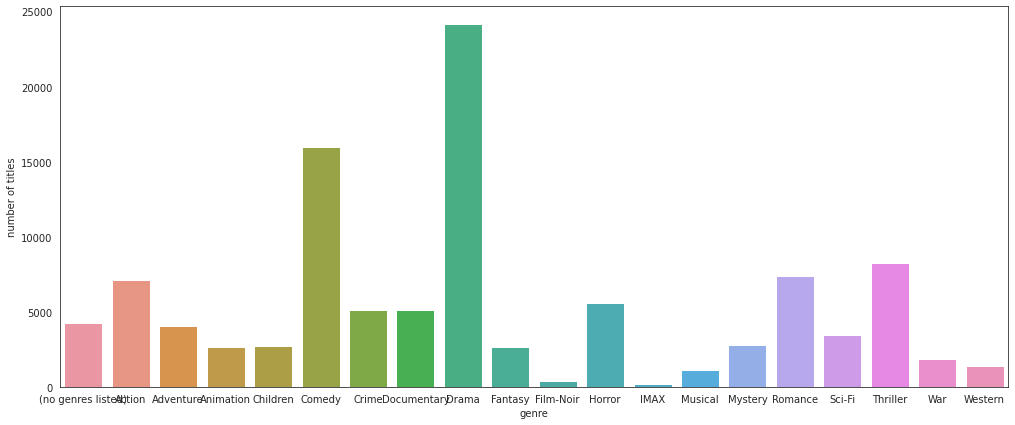

In [ ]:
# Creating barplot
plt.figure(figsize=(17,7))
sns.barplot(x= 'genre',y= 'number of titles', data=genre_counts)

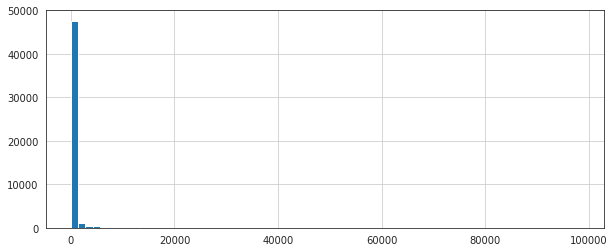

In [ ]:
# Creating histograms
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

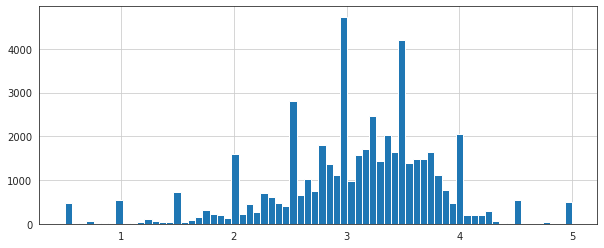

In [ ]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

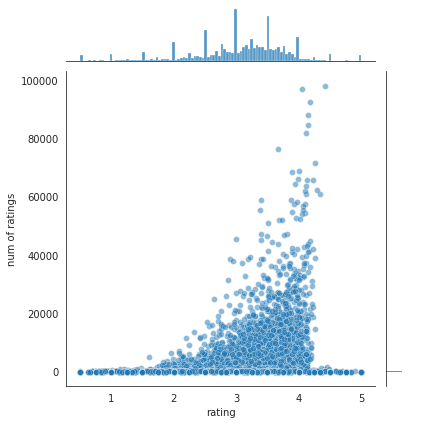

In [ ]:
# Scatter plot of ratings vs number of ratings
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Collaborative Filtering, often known as User-User Filtering, is the name of the approach. This strategy, as its other name suggests, involves other users recommending products to the input user. It seeks for users who share the input's likes and viewpoints, and then recommends goods that they have enjoyed to the input. There are various approaches for locating comparable users (including ones that employ Machine Learning), but the one we'll use here is based on the Pearson Correlation Function.

The following is the procedure for developing a User-Based Recommendation System:
- Choose a user based on the movies they've seen. - Find the top X neighbors based on their movie ratings.
- For each neighbor, get the user's viewed movie record.
- Using a formula, calculate a similarity score.
- Recommend the things that received the highest rating.

In [ ]:
user = [
            {'title':'Breakfast Club, The', 'rating':4},
            {'title':'Toy Story', 'rating':2.5},
            {'title':'Jumanji', 'rating':3},
            {'title':"Pulp Fiction", 'rating':4.5},
            {'title':'Akira', 'rating':5}
         ] 
inputMovie = pd.DataFrame(user)
inputMovie

,title,rating
0,"Breakfast Club, The",4.0
1,Toy Story,2.5
2,Jumanji,3.0
3,Pulp Fiction,4.5
4,Akira,5.0


The movieId column from the movie dataframe must now be added to the inputMovie Dataframe.
After filtering out the rows containing the titles of the input movies, merge this subset with the input dataframe. To reduce memory, we also remove unneeded columns from the input.

In [ ]:
#Filtering out the movies by title
Id = movie[movie['title'].isin(inputMovie['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovie = pd.merge(Id, inputMovie)
#Dropping information we won't use from the input dataframe
inputMovie = inputMovie.drop('year', 1)
inputMovie

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,movieId,title,rating
0,1,Toy Story,2.5
1,2,Jumanji,3.0
2,296,Pulp Fiction,4.5
3,1274,Akira,5.0
4,164600,Akira,5.0
5,1968,"Breakfast Club, The",4.0


**Using the rating dataframe to find users who have viewed the same movies**
We can now extract the subset of people who have watched and reviewed the movies in our input using the movie IDs.

In [ ]:
#Filtering out users that have watched movies that the input has watched and storing it
users = rating[rating['movieId'].isin(inputMovie['movieId'].tolist())]
users.head()

,userId,movieId,rating
42,4,1,4.0
43,4,2,4.0
107,4,296,5.0
234,4,1274,2.5
315,4,1968,0.5


In [ ]:
users.shape

(225950, 3)

In [ ]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = users.groupby(['userId'])

In [ ]:
#showing one such group example by getting all the users of a particular uderId
userSubsetGroup.groups.keys()
userSubsetGroup.get_group(604)

,userId,movieId,rating
61843,604,2,4.0
61889,604,1968,4.0


In [ ]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

In [ ]:
userSubsetGroup[0:3]

[(4,      userId  movieId  rating
  42        4        1     4.0
  43        4        2     4.0
  107       4      296     5.0
  234       4     1274     2.5
  315       4     1968     0.5), (56,       userId  movieId  rating
  4742      56        1     2.5
  4743      56        2     3.5
  4786      56      296     2.5
  4912      56     1274     4.5
  4989      56     1968     2.0), (134,        userId  movieId  rating
  12112     134        1     5.0
  12113     134        2     4.0
  12153     134      296     4.5
  12272     134     1274     4.5
  12362     134     1968     4.0)]

**User similarity to input user**
Next, we'll compare all users to our selected user to see which one is the most similar.
The Pearson Correlation Coefficient will be used to determine how similar each user is to the input. It's a metric for determining the strength of a linear relationship between two variables. The figure below shows the formula for calculating this coefficient between sets X and Y with N values.

Why Pearson Correlation?

Pearson correlation remains unchanged when all items are multiplied by a nonzero constant or when any constant is added to all elements. pearson(X, Y) == pearson(X, 2 * Y + 3), for example, if you have two vectors X and Y. This is a crucial trait in recommendation systems because, for example, two users may rate two series of objects in absolute terms that are completely different, yet they are comparable users (i.e., with similar thoughts) with similar rates on multiple scales.

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation") 

The formula returns values ranging from r = -1 to r = 1, with 1 indicating a direct correlation between the two entities (perfect positive correlation) and -1 indicating a perfect negative correlation.

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

In [ ]:
# userSubsetGroup = userSubsetGroup[0:100]

In [ ]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovie = inputMovie.sort_values(by='movieId')
    #Get the N for the formula
    n = len(group)
    #Get the review scores for the movies that they both have in common
    temp = inputMovie[inputMovie['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp['rating'].tolist()
    #put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(n)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(n)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorDict[name] = 0


In [ ]:
pearsonCorDict.items()

dict_items([(4, -0.2475059943583894), (56, 0.3616821166278092), (134, -0.2017366461964786), (239, 0.044022545316281775), (549, 0.34099716973523686), (605, -0.4952965120546658), (867, 0.29686241759717696), (953, 0.7781270639007186), (1068, 0.46380629477160623), (1185, 0.9616447378918993), (1191, 0.04402254531627865), (1212, -0.17609018126512815), (1471, 0.6102745452006318), (1695, 0.7781270639007126), (1991, 0.43133109281375515), (2025, 0.21304071579546996), (2329, -0.17609018126512427), (2720, 0.3509885473947315), (3344, 0.9149914219956283), (3665, -0.6132846549348309), (4372, 0.9644856443408245), (4377, 0.25219263977090295), (4507, -0.5187513759338097), (4605, -0.07746935119835283), (5159, 0.5155392622264673), (5356, -0.6990252954195317), (5396, 0.26413527189768876), (5574, 0.5155392622264673), (5742, 0.26413527189768593), (5838, 0.20173664619648324), (5953, 0.10783277320343994), (6264, -0.24041118447297505), (6274, 0.7009130258223482), (6278, 0.4921870193488488), (6299, 0.03251280443

In [ ]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,-0.247506,4
1,0.361682,56
2,-0.201737,134
3,0.044023,239
4,0.340997,549


In [ ]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
16032,1.0,136245
22065,1.0,244718
20510,1.0,216906
9332,1.0,15753
18206,1.0,175904


**All movies are rated by a group of users** 
We'll do this by taking the weighted average of the movie ratings, with the Pearson Correlation serving as the weight. However, in order to do so, we must first obtain the movies seen by users in our pearsonDF from the ratings dataframe, and then store their correlation in a new column called _similarityIndex." This is accomplished by combining these two tables as shown below.

In [ ]:
topUsersRating=topUsers.merge(rating, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,136245,2,2.0
1,1.0,136245,9,1.0
2,1.0,136245,10,4.0
3,1.0,136245,18,4.0
4,1.0,136245,24,4.0


::Multiply the movie's rating by its weight (the similarity index), then add the new ratings together and divide by the sum of the weights. 

We can easily accomplish this by multiplying two columns, grouping the dataframe by movieId, and then dividing the dataframe into two columns:

In [ ]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,136245,2,2.0,2.0
1,1.0,136245,9,1.0,1.0
2,1.0,136245,10,4.0,4.0
3,1.0,136245,18,4.0,4.0
4,1.0,136245,24,4.0,4.0


In [ ]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,23.0,40.0
2,36.0,77.5
3,7.0,19.0
4,3.0,6.5
5,10.0,27.0


In [ ]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,1.739130,1
2,2.152778,2
3,2.714286,3
4,2.166667,4
5,2.700000,5


In [ ]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
4077,5.0,4077
1078,5.0,1078
2295,5.0,2295
1218,5.0,1218
1216,5.0,1216
26228,5.0,26228
487,5.0,487
5147,5.0,5147
7099,5.0,7099


In [ ]:
movie.loc[movie['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,year
483,487,Lightning Jack,1994
1056,1078,Bananas,1971
1190,1216,"Big Blue, The (Grand bleu, Le)",1988
1192,1218,"Killer, The (Die xue shuang xiong)",1989
2211,2295,"Impostors, The",1998
2258,2342,Hard Core Logo,1996
3984,4077,"With a Friend Like Harry... (Harry, un ami qui...",2000
5052,5147,Wild Strawberries (Smultronstället),1957
6988,7099,Nausicaä of the Valley of the Wind (Kaze no ta...,1984
8705,26228,"Swedish Love Story, A (Kärlekshistoria, En)",1970
